In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Embedding, Reshape, Conv1D, MaxPool1D, Dropout
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# **Read Data**

In [3]:
data = pd.read_csv('data.txt')

In [4]:
data.head()

,1
0,ای رستخیز ناگهان، وی رحمت بی منتها\tای آتشی اف...
1,امروز خندان آمدی، مفتاح زندان آمدی\tبر مستمندا...
2,خورشید را حاجب تویی، امید را واجب تویی\tمطلب ت...
3,در سینه ها برخاسته، اندیشه را آراسته\tهم خویش ...
4,ای روح بخش بی بَدَل، وی لذتِ علم و عمل\tباقی ب...


**Read Stop-Words**

In [5]:
def read_stop_words(filename):
  with open(filename) as stopwords_file:
    stopwords = stopwords_file.readlines()
  stopwords = [line.replace('\n', '') for line in stopwords] 
  return stopwords

In [6]:
stopwords = read_stop_words('stopwords.txt')
print(len(stopwords))

1382


**hazm library**

In [7]:
# install hazm library
!pip install hazm
from hazm import word_tokenize

### **Preprocess the text**

In [8]:
# preprocess the text
def text_preprocess(data):
  text = [line.replace('\t', ' ') for line in data.values.flatten()]
  text = [line.replace('-', ' ') for line in text]
  text = [re.sub("\d+", "", t) for t in text]

  word_tokenized = [word_tokenize(t) for t in text]
  word_tokenized_filtered = [[w for w in sentence if w not in stopwords] for sentence in word_tokenized]

  sentences = [' '.join(sentence) for sentence in word_tokenized_filtered]
  sentences = [sentence for sentence in sentences if sentence != '']

  return sentences


In [9]:
sentences = text_preprocess(data)

In [10]:
sentences[0]

'رستخیز رحمت منتها آتشی افروخته بیشه اندیشه'

### **get less frequente words**

In [11]:
def get_all_sentences():
  all_sentences = ''
  sentences = text_preprocess(data)
  for sentence in sentences:
    all_sentences += sentence
    all_sentences += ' '

  return all_sentences  

In [12]:
def get_word_freq(vocabularies):
  word_freq = []
  for vocab in vocabularies:
    word_freq.append(vocabularies.count(vocab))
  return word_freq  

In [13]:
# get the words that frequentes less than 3 times in the corpus
def get_less_frequente_words():
  low_frequency_words = []
  all_sentences = get_all_sentences()
  vocabularies = all_sentences.split(' ')
  word_freq = get_word_freq(vocabularies)

  for i in range(len(word_freq)):
    if word_freq[i] < 3:
      low_frequency_words.append(vocabularies[i])

  return low_frequency_words

In [14]:
less_frequente_words = get_less_frequente_words()

In [15]:
print(len(less_frequente_words))

9508


## **remove less frequente words**

In [16]:
# remove the words that frequentes less than 3 times in the corpus
def remove_less_frequente_words(less_frequente_words, sentences):
  sentences_tokenized = [word_tokenize(sentence) for sentence in sentences]
  sentences_tokenized_filtered = [[w for w in sentence if w not in less_frequente_words] for sentence in sentences_tokenized]
  corpus = [' '.join(sentence) for sentence in sentences_tokenized_filtered]
  corpus = [sentence for sentence in corpus if sentence != '']

  return corpus

In [17]:
corpus = remove_less_frequente_words(less_frequente_words, sentences)

In [18]:
corpus[0:10]

['رحمت منتها آتشی افروخته بیشه اندیشه',
 'خندان آمدی مفتاح زندان آمدی آمدی بخشش فضل خدا',
 'خورشید تویی امید واجب تویی مطلب تویی طالب تویی منتها',
 'سینه اندیشه آراسته حاجت روا',
 'روح علم باقی بهانه دغل علت دوا',
 'دغل کژ گنه کین مست مست نان',
 'هل عقل هل نان نشاید ماجرا',
 'تدبیر رنگ افکنی روم زنگ افکنی جنگ افکنی یری',
 'پنهان گوش جان بهانه کسان جان رب زنان والله کیا',
 'خامش رفتم پای علم بنه بشکن قلم ساقی درآمد الصلا']

## **Tokenizer**

In [19]:
# tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

In [20]:
with open('tokenizer.h5', 'wb') as f:
    pickle.dump(tokenizer, f)

In [66]:
list(tokenizer.word_index.items())[0:10]

[('جان', 1),
 ('دل', 2),
 ('عشق', 3),
 ('آب', 4),
 ('چشم', 5),
 ('شب', 6),
 ('جهان', 7),
 ('شمس', 8),
 ('دست', 9),
 ('مست', 10)]

In [22]:
 # find more stopwords by sorting the tokenizer word counts
#  word_count_sorted = dict(sorted(tokenizer.word_counts.items(), reverse=False, key=lambda t: t[1]))
#  word_count_sorted

In [23]:
encoded = tokenizer.texts_to_sequences(corpus)

In [24]:
encoded[0:10]

[[283, 1332, 395, 1605, 961, 142],
 [185, 565, 1118, 396, 565, 565, 826, 332, 23],
 [46, 29, 633, 2025, 29, 827, 29, 258, 29, 1332],
 [92, 142, 1333, 723, 724],
 [30, 221, 162, 397, 1606, 962, 244],
 [1606, 725, 2026, 566, 10, 10, 209],
 [464, 13, 464, 209, 1119, 417],
 [963, 104, 1607, 350, 1120, 1607, 192, 1607, 726],
 [75, 41, 1, 397, 1608, 1, 259, 245, 284, 1121],
 [201, 727, 56, 221, 375, 728, 1122, 31, 567, 186]]

In [25]:
num_all_words = sum(len(s) for s in encoded) # total number of words in the corpus
num_unique_words = len(tokenizer.word_index) + 1  # total number of unique words in the corpus

In [26]:
num_all_words, num_unique_words

(29456, 2722)

### **Generate data**

In [27]:
# Parameters
window_size = 2

In [28]:
def generate_data(corpus, window_size, num_unique_words):
    maxlen = window_size * 2
    all_inputs = []
    all_outputs = []
    for words in corpus:
      len_words = len(words)
      for index,w in enumerate(words):
        s = index - window_size
        e = index + window_size + 1
        for i in range(s, e):
            if i != index and 0 <= i < len_words:
              #all_inputs.append(w) 
              all_inputs.append(to_categorical(w, num_unique_words)) 
              all_outputs.append(to_categorical(words[i], num_unique_words))

    return (np.array(all_inputs), np.array(all_outputs))

In [29]:
# Create training data
X_train, y_train = generate_data(encoded, window_size, num_unique_words)
X_train.shape, y_train.shape

((86230, 2722), (86230, 2722))

In [30]:
X_train, y_train

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

In [31]:
# for i in X_train:
#   print(np.where(i == 1))
print(np.where(X_train[0] == 1))

(array([283]),)


## **Create Neural Network**

In [32]:
input1 = Input(shape=(X_train.shape[1],))
dense1 = Dense(units=100, activation='linear')(input1)
output1 = Dense(units=y_train.shape[1], activation='softmax')(dense1)
model = Model(inputs=input1, outputs=output1)

# model = Sequential()
# model.add(Input(shape=(X_train.shape[1],)))
# model.add(Dense(units=50, activation='linear'))
# model.add(Dense(10, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(units=y_train.shape[1], activation='softmax'))

In [33]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2722)]            0         
                                                                 
 dense (Dense)               (None, 100)               272300    
                                                                 
 dense_1 (Dense)             (None, 2722)              274922    
                                                                 
Total params: 547,222
Trainable params: 547,222
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = model.fit(X_train, y_train, epochs=50, verbose=1, batch_size=2048, validation_split=0.2)

Epoch 1/50
34/34 [==============================] - 10s 277ms/step - loss: 7.8857 - accuracy: 0.0204 - val_loss: 7.8457 - val_accuracy: 0.0198
Epoch 2/50
34/34 [==============================] - 8s 234ms/step - loss: 7.6903 - accuracy: 0.0284 - val_loss: 7.5729 - val_accuracy: 0.0199
Epoch 3/50
34/34 [==============================] - 8s 233ms/step - loss: 7.3215 - accuracy: 0.0284 - val_loss: 7.3725 - val_accuracy: 0.0199
Epoch 4/50
34/34 [==============================] - 8s 235ms/step - loss: 7.1644 - accuracy: 0.0284 - val_loss: 7.3734 - val_accuracy: 0.0199
Epoch 5/50
34/34 [==============================] - 8s 236ms/step - loss: 7.1351 - accuracy: 0.0284 - val_loss: 7.3850 - val_accuracy: 0.0199
Epoch 6/50
34/34 [==============================] - 8s 235ms/step - loss: 7.1213 - accuracy: 0.0284 - val_loss: 7.3934 - val_accuracy: 0.0199
Epoch 7/50
34/34 [==============================] - 8s 235ms/step - loss: 7.1089 - accuracy: 0.0284 - val_loss: 7.3998 - val_accuracy: 0.0199
Epoch

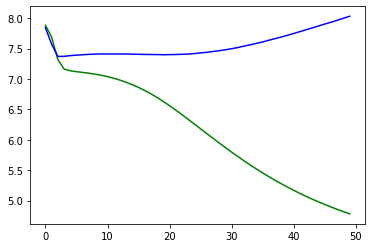

In [36]:
plt.plot(history.history['loss'], color='green', label='Train Data')
plt.plot(history.history['val_loss'], color='blue', label='Validation Data')

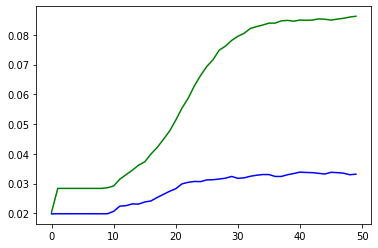

In [37]:
plt.plot(history.history['accuracy'], color='green', label='Train Data')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation Data')

In [38]:
model.save('word2vec.h5')

## **Load Model**

In [39]:
# laod model
model = load_model('word2vec.h5')

In [40]:
model

### **Get Most Similarity**

In [43]:
with open('tokenizer.h5', 'rb') as f:
    tokenizer = pickle.load(f)

In [44]:
def get_most_similarity(word, model=model, tokenizer=tokenizer, n=15):
  num_unique_words = len(tokenizer.word_index) + 1
  word_to_sequences = tokenizer.texts_to_sequences([word])[0]
  word_to_sequences_one_hot = to_categorical(word_to_sequences, num_unique_words)
  prediction = model.predict(word_to_sequences_one_hot)[0]
  index = np.argsort(prediction)[::-1][:n]
  sequences_to_word = tokenizer.sequences_to_texts([index])[0]
  most_similarity = sequences_to_word.split(' ')
  return most_similarity

In [45]:
get_most_similarity('عشق')

['عشق',
 'جان',
 'دل',
 'عقل',
 'آتش',
 'عاشقان',
 'جمله',
 'جهان',
 'شمس',
 'ملک',
 'مست',
 'گشته',
 'روح',
 'گشت',
 'چرخ']

In [46]:
get_most_similarity('جان')

['جان',
 'دل',
 'تن',
 'عشق',
 'جهان',
 'فزا',
 'دست',
 'ساقی',
 'آب',
 'عاشقان',
 'ذره',
 'هزاران',
 'غم',
 'حیات',
 'پاک']

In [47]:
get_most_similarity('کنج')

['عاشق',
 'ای',
 'کنجی',
 'کنج',
 'خلا',
 'نشین',
 'زندان',
 'درآرد',
 'زهر',
 'خلوت',
 'کف',
 'فنا',
 'سودا',
 'منه',
 'جهان']

## **Get Weights and draw plot**

In [55]:
# get input weights
weights = model.get_weights()[0]

In [56]:
len(weights)

2722

In [57]:
embedding_dict = {}
for word,index in tokenizer.word_index.items(): 
    embedding_dict.update({
        word: weights[index]
        })

In [64]:
list(embedding_dict.items())[0]

('جان', array([-0.47895724,  0.34652632, -0.01061946, -0.23760271,  0.6077599 ,
        -0.15337832,  0.47511327, -0.41616496, -0.23796754,  0.35000712,
        -0.20956564, -0.05906914,  0.06320841, -0.31683043,  0.1907848 ,
         0.53209764,  0.1590492 ,  0.10880703,  0.27821156, -0.29791474,
         0.03440914,  0.5735275 ,  0.66250557, -0.03460001,  0.1031165 ,
        -0.01640874,  0.13187419, -0.02488641,  0.04446852, -0.04754214,
         0.5210572 , -0.4055186 ,  0.53696656,  0.4247631 , -0.42383602,
         0.6401769 ,  0.13687167,  0.38019603,  0.3522692 ,  0.23543994,
        -0.40241954, -0.33368623, -0.47799736, -0.6061638 ,  0.267123  ,
        -0.25688562,  0.50415355, -0.33742586, -0.46959177, -0.19451849,
        -0.68983424, -0.2051024 ,  0.23267266,  0.50165427,  0.10545728,
         0.23609261,  0.11131634, -0.07940164, -0.12612227,  0.34253415,
         0.18908823,  0.38115922, -0.43771586,  0.05808201, -0.54259783,
         0.00591518, -0.17087054, -0.0679300

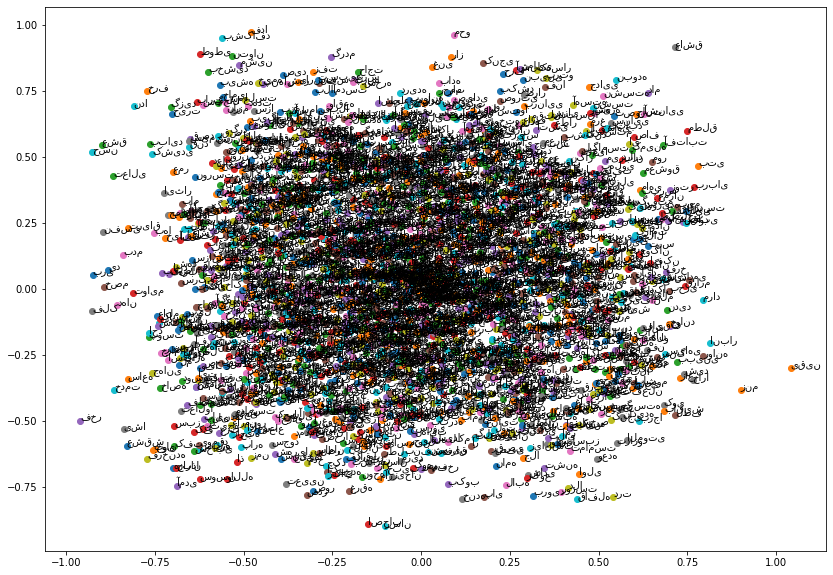

In [65]:
plt.figure(figsize=(14, 10))
for word in list(tokenizer.word_index.keys()):
    coord = embedding_dict.get(word)
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1]))  